# Neural Dependency Parsing

Derived from code for Stanford CS224N, by:
- Sahil Chopra <schopra8@stanford.edu>
- Haoshen Hong <haoshen@stanford.edu>

In this homework, you’ll be implementing a neural-network based dependency parser with the goal of maximizing performance on the UAS (Unlabeled Attachment Score) metric.

A dependency parser analyzes the grammatical structure of a sentence, establishing relationships between head words, and dependent words which modify those heads.
There are several types of dependency parsers, including transition-based parsers, graph-based parsers, and feature-based parsers. Your implementation will be a transition-based parser, which incrementally builds up a parse one step at a time.
The parser maintains a state, which is represented as follows:

- A `stack` of words that are currently being processed.
- A `buffer` of words yet to be processed.
- A `list` of dependencies predicted by the parser.

Initially, the stack only contains `ROOT`, the dependencies list is empty, and the buffer contains the list of words of the sentence. At each step, the parser applies a transition to its state until its buffer is empty and the stack size is 1.
The following transitions can be applied:

- `SHIFT`: removes the first word from the buffer and pushes it onto the stack.
- `LEFT-ARC`: marks the second (second most recently added) item on the stack as a dependent of the first item and removes the second item from the stack, adding a first word → second word dependency to the dependency list.
- `RIGHT-ARC`: marks the first (most recently added) item on the stack as a dependent of the second item and removes the first item from the stack, adding a second word → first word dependency to the dependency list.

On each step, your parser will decide among the three transitions using a neural network classifier.

# 1   Preliminaries

## 1.1  Transitions
Provide the sequence of Attardi’s non-projective transitions for parsing the following sentence:

`The president scheduled a meeting yesterday that nobody attended.`

## 1.2 Features

*What is the difference in terms of features between neural network dependency parsers (e.g. Chen&Manning 2014, https://cs.stanford.edu/~danqi/papers/emnlp2014.pdf) and non-neural network dependency parsers (e.g. parsers with lots of features like Zhang&Nivre 2011, www.anthology.aclweb.org/P/P11/P11-2033.pdf), in particular in terms of sparsity?*

## 1.3  Ambiguity

*What is the ambiguity in parsing the following sentence?*<br/>
`There are statistics about poverty that no one is willing to accept`

## 1.4 Parse Tree

*Mention which errors that make the following an incorrect dependency tree:*

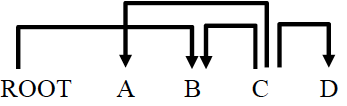

## Exercise 1.
Implement the `__init__` and `step` methods in the `ParseState` class in `parser_state.py`. This implements the transition mechanics your parser will use.

In [1]:
from parser_state import ParserState

We will represent sentences as list of tokens, where tokens are named tuples:

In [2]:
from collections import namedtuple

Token = namedtuple('Token', ['id', 'form', 'pos', 'head', 'deprel'], defaults=(0,)*5)

Example of a sentence:

In [3]:
[Token(1, 'The'), Token(2, 'cat')]

[Token(id=1, form='The', pos=0, head=0, deprel=0),
 Token(id=2, form='cat', pos=0, head=0, deprel=0)]

## Test a single parser step

In [4]:
def test_step(transition, stack, buf, deps,
              ex_stack, ex_buf, ex_deps):
    """Tests that a single parse step returns the expected output"""
    ps = ParserState([Token(i, f) for i,f in enumerate(stack)],
                    [Token(i + len(stack), f) for i,f in enumerate(buf)],
                    deps)
    
    ps.step(ps.tr2id[transition]) # covert action name to it numeric id
    stack = [t.form for t in ps.stack] # collect the words
    buf = [t.form for t in ps.buffer]
    deps = [(a[0].form, a[1].form) for a in sorted(ps.arcs)]
    assert stack == ex_stack, \
        f"{transition} test resulted in stack {stack}, expected {ex_stack}"
    assert buf == ex_buf, \
        f"{transition} test resulted in buffer {buf}, expected {ex_buf}"
    assert deps == ex_deps, \
        "{transition} test resulted in dependency list {deps}, expected {ex_deps}"
    print(f"{transition} test passed!")

Perform a few tests:

In [5]:
test_step("S", ["ROOT", "the"], ["cat", "sat"], [],
          ["ROOT", "the", "cat"], ["sat"], [])
test_step("LA", ["ROOT", "the", "cat"], ["sat"], [],
          ["ROOT", "cat"], ["sat"], [("cat", "the")])
test_step("RA", ["ROOT", "run", "fast"], [], [],
          ["ROOT", "run"], [], [("run", "fast")])

S test passed!
LA test passed!
RA test passed!


## Test parsing a sentence

In [6]:
ROOT = Token(0, 'ROOT')

def test_parse():
    """Simple tests for the PartialParse.parse function.
    Warning: these are not exhaustive.
    """
    sentence = [Token(i+1, f) for i,f in enumerate(["parse", "this", "sentence"])]
    state = ParserState(stack=[ROOT], buffer=sentence)
    dependencies = state.parse(["S", "S", "S", "LA", "RA", "RA"])
    dependencies = [(a[0].form, a[1].form) for a in sorted(dependencies)]
    expected = [('ROOT', 'parse'), ('parse', 'sentence'), ('sentence', 'this')]
    assert dependencies == expected, \
        f"parse test resulted in dependencies {dependencies}, expected {expected}"
    assert [t.form for t in sentence] == ["parse", "this", "sentence"], \
        f"parse test failed: the input sentence should not be modified"
    print("parse test passed!")

In [7]:
test_parse()

parse test passed!


# Exercise 2

We are now going to train a neural network to predict, given the state of the stack, buffer, and dependencies, which transition should be applied next.<br/>
First, the model extracts a feature vector representing the current state. We will be using the feature set presented in the  paper by  Chen and Manning (2014), "A Fast and Accurate Dependency Parser using Neural Networks", https://nlp.stanford.edu/pubs/emnlp2014-depparser.pdf.

The method `ParserState.extract_features()` to extract these features is  implemented in `parser_state.py`.
These features consist of a triple:
- a list of tokens (e.g., the last word in the stack, first word in the buffer, dependent of the second-to-last word in the stack if there is one, etc.).
- a list of POS tags for the same tokens
- a list of DEPRELs for the same tokens.
Each element is represented by an integer ids, and therefore it consists of:

$$[ [w_1,w_2,...,w_m], [p_1, p_2,...,p_m], [d_1, d_2,..., d_m] ]$$

where $m$ is the number of features and each $0 ≤ w_i < |V|$ is the index of a token in the vocabulary ($|V|$ is the vocabulary size) and similarly for $p_i$ and $d_i$.
Then our network looks up an embedding for each word and tags and concatenates them into a single input vector:
$$x = [E_{w_1},...,E_{w_m},Ep_{p_1},...,Ep_{p_m},Ed_{d_1},...,Ed_{d_m}] ∈ \mathbb{R}^{(d+d_p+d_d)m}$$
where $E ∈ \mathbb{R}^{|V|×d}$ is an embedding matrix with each row $E_w$ as the vector for a particular word $w$, and similarly $Ep$ and $Ed$ for tags, with dimesions respectively $d_p$ and $d_d$.<br/>
We then compute our prediction as:
$$h = ReLU(xW + b_1)$$
$$l = hU + b_2$$
$$\hat{y} = softmax(l)$$
where $h$ is referred to as the hidden layer, $l$ is referred to as the logits, $\hat{y}$ is referred to as the predictions, and $ReLU(z) = max(z, 0)$. We will train the model to minimize cross-entropy loss:
$$J(θ) = CE(y,\hat{y}) = \sum_{i=1}^a{−y_i log \hat{y}_i}$$
where $a$ is the number of possible parser actions.
To compute the loss for the training set, we average this $J(θ)$ across all training examples.
We will use UAS score as our evaluation metric. UAS refers to Unlabeled Attachment Score, which is computed as the ratio between number of correctly predicted dependencies and the number of total dependencies irrespective of the relations.

In `model.py` you will find skeleton code to implement this simple neural network using Keras. Complete the `__init__` methods to implement the model.

Then complete the train for epoch and train functions. Finally execute python `run.py` to train your model and compute predictions on test data from Penn Treebank (annotated with Universal Dependencies), available in files `data/traing.gold.conll`, `data/dev.gold.conll` and `data/test.gold.conll`.

##Note:##


## Load the training data

In [5]:
from corpus import read_conll

train_file = 'data/train.gold.conll'
dev_file = 'data/dev.gold.conll'
test_file = 'data/test.gold.conll'

max_sent = 500 # limit sentences during development

train_sents = read_conll(train_file, max_sent=max_sent)
dev_sents = read_conll(dev_file, max_sent=max_sent//2)
test_sents = read_conll(test_file, max_sent=max_sent//2)

## Create the parser

In [6]:
from parser import Parser

parser = Parser(train_sents)

## Convert to numeric vectors

In [7]:
train_vectors = parser.vectorize(train_sents)
dev_vectors = parser.vectorize(dev_sents)

## Build the training set

In [8]:
train_x, train_y = parser.create_features(train_vectors)
dev_x, dev_y = parser.create_features(dev_vectors)

100%|██████████| 250/250 [04:30<00:00,  1.08s/it]


Show sample of features:

In [9]:
dev_x[3], dev_y[3]

(([2, 0, 3228, 1469, 310, 3195, 2, 235, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
  [2, 0, 8, 12, 34, 21, 2, 38, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 0)

## Build the datasets

In [10]:
from tensorflow.data import Dataset

ds_train = Dataset.from_tensor_slices((train_x, train_y)).shuffle(1000).batch(32)
ds_dev = Dataset.from_tensor_slices((dev_x, dev_y)).shuffle(1000).batch(32)

## Load the embeddings

In [11]:
from glove import Glove

emb_path = 'data/en-cw.txt'

glove = Glove(glove_path)

## Prepare embedding matrix
Trimmed to the parser vocabulary.

In [8]:
num_tokens = len(parser.tok2id)
embedding_dim = len(next(iter(glove.wv.values())))

import numpy as np

# Fill the matrix with Glove embeddings
embedding_matrix = np.random.uniform(-1, 1, (num_tokens, embedding_dim))
for word, i in parser.tok2id.items():
    embedding_vector = glove.wv.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be random.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector

## Create the model

In [ ]:
from model import ParserModel

n_features = len(train_x[0][0])
n_pos = len(parser.pos2id)
n_tags = len(parser.dep2id)
tag_size = 20 # size of embeddings for POS and DEPRELs 
n_actions = n_tags * 2 + 1 # L-d + R-d + 1
hidden_size = 200

model = ParserModel(embeddings=embedding_matrix, n_features=n_features,
                    n_pos=n_pos, n_tags=n_tags, tag_size=tag_size,
                    n_actions=n_actions, hidden_size=hidden_size)

Show the model

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

## Train the model

Choose an optimizer: `SparseCategoricalCrossentropy` expects numerical categories.

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

Compile the model:

In [ ]:
from tensorflow import keras

model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(name='train_loss'),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='train UAS')],
)

Train the model:

In [ ]:
EPOCHS = 3
history = model.fit(ds_train, epochs=EPOCHS,
                    validation_data=ds_dev)

# Test the model

In [ ]:
UAS, LAS = parser.parse(test_sents, model)
print(f'UAS: {UAS*100:.2f}, LAS: {LAS*100:.2f}')

If you have time: train the parser on the whole training set with more EPOCS and report the UAS/LAS taht you achiecve on the test set.

## Exercise 3 (optional)

Modify the `Parser.parse()` method to print the parsed sentences in CoNLL-U format.

## Exercise 4

Let's explore the ability of the parser to handle common mistakes.

Consider the following kind of errors:

1. **Prepositional Phrase Attachement Error.**
This occurs when a prepositional phrase is attached to wrong head word. 
1. **Verb Phrase Attachement Error.**
This occurrs when a verb phrase is attached to the wrong head word.
1. **Modifier Attachemnt Error.**
This occurrs when a modifier (adjective or adverb) is attached to the wrong head word.
1. Coordination Attachment Error:
This occurrs when a conjuct is attached to the wrong head wor.

Check whether the parser does any of these mistakes on these sentences and classify them according to the 4 types above:

- `Moscow sent troops to Afghaninstan`
- `I disembarked and was heading to a wedding fearing for my death`
- `It makes me want to rush out and rescue people from dilemmas of their own making.`
- `Brian has been one of the most crucial elements to the success of Mozilla.`

# Submission instructions

1. Make a zip with your code and notebook (without the data folder), i.e.

    zip &lt;YourName&gt;.zip *.ipynb *.py
    
1. Submit though Moodle on https://elearning.di.unipi.it/mod/assign/view.php